# Control variates for a GARCH model

Ce notebook répond à la **première question** du projet. En suivant les directives de l'article, on implémente un échantillonneur de Metropolis-Hastings basé sur une marche aléatoire pour estimer les paramètres d'un modèle GARCH(1,1). On commence par l'utilisation de données simulées, puis on étend l'analyse à des données réelles. Ces données réelles sont des rendements logarithmiques des taux de change, dont la source est donnée ci-après.

## Importation des libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from arch.univariate import GARCH, ZeroMean
import pandas as pd 
from math import log 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import statsmodels.api as sm

## Échantillonnage des données simulées selon un modèle Normal-GARCH(1,1)  

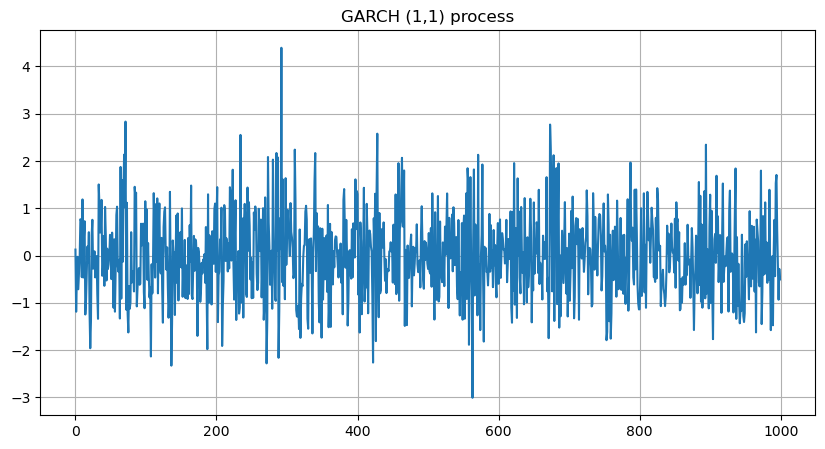

In [2]:

np.random.seed(12345)

n = 1000        # n le nombre d'observations à générer
n1 = 100        # n1 est le nombre des observations premières qu'on supprime de l'échantillon 
n2 = n + n1     # n2 est le nombre de simulations total

# Les paramètres de GARCH(1,1)
omega = 0.1
alpha = 0.2   
beta = 0.7

errors = np.random.normal(0,1,n2) 
h2 = np.zeros(n2)
r = np.zeros(n2)
h2[0] = omega

for i in range(1,n2-1): 
    h2[i] = omega + alpha*h2[i-1]*errors[i-1]**2 + beta*h2[i-1]
    r[i] = np.sqrt(h2[i])*errors[i]

h = h2[n1-1:-1]
y = r[n1-1:-1]    # On élimine les premières observations

plt.figure(figsize=(10, 5))
plt.title('GARCH (1,1) process')
x = range(n) 
plt.plot(x,y)
plt.grid(True)
plt.show()

## Récupération des données réelles 

On calcule la transformation logarithmique du taux de change Euro/US Dollar journalier sur la période entre 24/04/2021 et 24/04/2024.

- Source : https://www.investing.com/currencies/eur-usd-historical-data

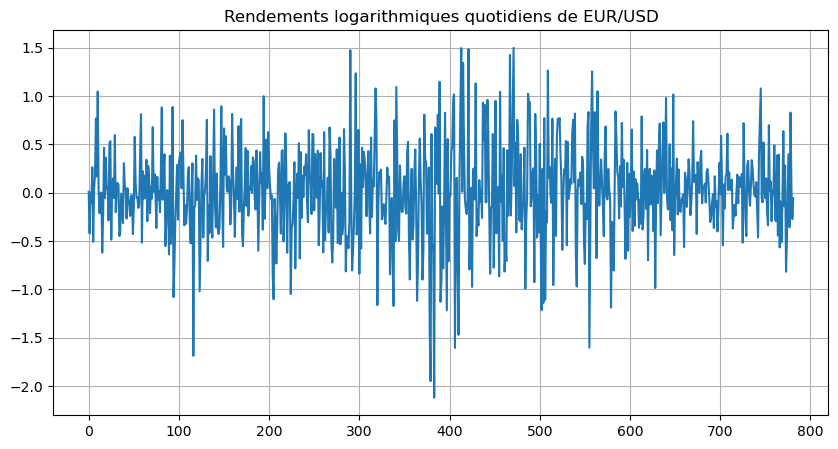

In [5]:
Prix = pd.read_csv("EUR_USD Historical Data.csv")['Price']
r = []
for i in range(len(Prix)-1) :
    r.append(log(Prix[i+1]/ Prix[i])*100)

plt.figure(figsize=(10, 5))
plt.title('Rendements logarithmiques quotidiens de EUR/USD')
x = range(len(r)) 
plt.plot(x,r)
plt.grid(True)
plt.show()

## Metropolis-Hastings sampler

Nous implémentons un échantillonneur Metropolis-Hastings avec marche aléatoire ciblant la distribution à posteriori des paramètres d'un modèle GARCH(1,1). Pour ce faire, nous suivons les étapes suivantes :

1. **Implémentation de la distribution à priori (priors) :** Nous choisissons une loi normale pour chaque paramètre \( \omega_i \). Les paramètres \( \omega_1 \), \( \omega_2 \) et \( \omega_3 \) sont supposés être indépendants. Nous sélectionnons de grandes variances pour que la distribution à posteriori reflète principalement les données et non nos propres croyances.

2. **Implémentation de la vraisemblance :** Dans un modèle GARCH(1,1), les rendements sont conditionnellement distribués selon une loi normale, \( r(t)|F_t \sim N(0, h_t) \), où \( h_t \) est donné par :
\[ h_t = \omega_1 + \omega_3 h_{t-1} + \omega_2 r_{t-1}^2 \]
La fonction de vraisemblance est donnée par :
\[ l(\omega_1, \omega_2, \omega_3|r) \propto \prod_{t=1}^{T} h_t^{-\frac{1}{2}} \exp \left( -\frac{1}{2} \sum_{t=1}^{T} \frac{r_t^2}{h_t} \right) \]
En utilisant des lois à priori normales et indépendantes pour les paramètres, la loi à posteriori est donnée par :
\[ \pi(\omega_1, \omega_2, \omega_3|r) \propto \exp \left( -\frac{1}{2} \left( \frac{\omega_1^2}{\sigma^2(\omega_1)} + \frac{\omega_2^2}{\sigma^2(\omega_2)} + \frac{\omega_3^2}{\sigma^2(\omega_3)} \right) \right) \prod_{t=1}^{T} h_t^{-\frac{1}{2}} \exp \left( -\frac{1}{2} \sum_{t=1}^{T} \frac{r_t^2}{h_t} \right) \]